In [1]:
import json
import pandas as pd
import numpy as np
import msgpack

def read_json(filename, **kwargs):
    with open(filename, "r") as f:
        content = json.load(f)
    for c in content:
        c.update(kwargs)
    return content

Goal:

* Mean/median plot over time
* 

Plan:

* read in JSONs in "tidy data"
* convert to DataFrame
* 

In [2]:
def shape_history(history, **kwargs):
    """
    TODO: get list of times, smooth over that
    
    out = []
    for row in history:
        time = next(times)
        if time < row["time"]:
            out += [out[-1]]
        out += [process(row)]  
    """
    
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "bracket": row["bracket"],
                 "random_state": row["random_state"],
                 "patience": row["patience"],
                 **kwargs}]
    return out

In [3]:
today = "sim/2019-06-28-"
RANDS = range(400, 403 + 1)

In [4]:
def fname(workers, random_state, patience):
    return f"-workers={workers}-rs={random_state}-patience={patience}"

workers = 16
histories = [
    read_json(today + fname(workers, rs, patience) + "-history.json", patience=patience, random_state=rs)
    for rs in RANDS
    for patience in [True, False]
]

In [5]:
medium_rare = [shape_history(hist) for hist in histories]
medium = sum(medium_rare, [])

In [22]:
df = pd.DataFrame(medium)
div = 10
df["elapsed_wall_time (binned)"] = (df.elapsed_wall_time // div) * div
df.head()

,best_score,bracket,cumulative_partial_fit_calls,elapsed_wall_time,patience,random_state,elapsed_wall_time (binned)
0,-0.140595,0,1,0.000000,True,400,0.0
1,-0.140595,0,2,0.000002,True,400,0.0
2,-0.140595,0,3,0.000003,True,400,0.0
3,-0.140595,0,4,0.000004,True,400,0.0
4,-0.140595,0,5,0.000005,True,400,0.0


(-0.09, -0.06)

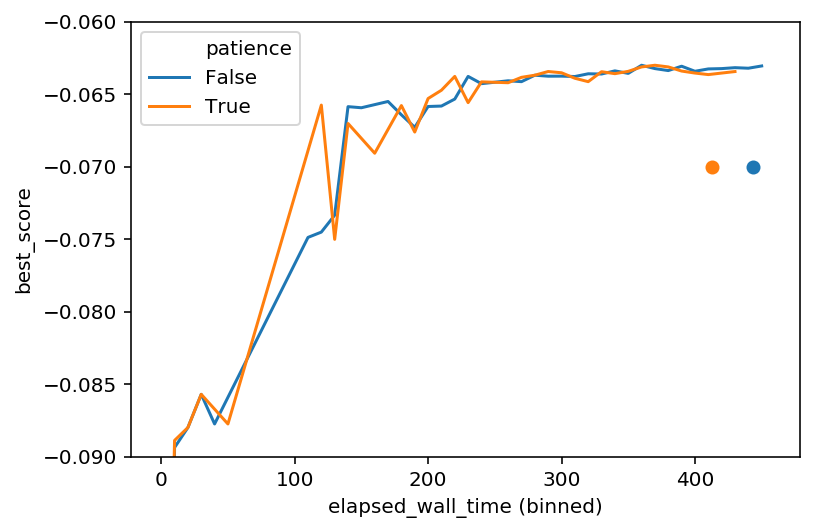

In [56]:
import seaborn as sns

def _get_last_score(df):
    d = df.reset_index()
    idx = d.cumulative_partial_fit_calls.idxmax()
    return d.loc[idx]

ax = sns.lineplot(
    data=df,
    x="elapsed_wall_time (binned)",
    y="best_score",
    hue="patience",
    ci=None,
)

# vals = 

for k, rs in enumerate(df.random_state.unique()):
    show = df[df.random_state == rs]
    wait = _get_last_score(show[show.patience == True])
    keep_going = _get_last_score(show[show.patience == False])
    ax.plot(keep_going.elapsed_wall_time, -(k + 1) * 0.07, "oC0")
    ax.plot(wait.elapsed_wall_time, -(k + 1) * 0.07, "oC1")
#     ax.plot()
    
ax.set_ylim(-0.09, -0.06)